In [ ]:
#import important libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pydot
import pandas as pd
import itertools

In [ ]:
#imports for building the model
from tensorflow.keras.applications import ResNet50, ResNet50V2, MobileNetV2, VGG19, InceptionResNetV2, ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
#Loads Resnet50 model with pre-trained weights
#base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D

# Assuming `base_model` is your pre-trained model and its layers are not set as non-trainable yet
base_model.trainable = False

# Start with the base model's output
x = base_model.output

# Add Global Average Pooling to reduce the spatial dimensions
x = GlobalAveragePooling2D()(x)

# Continue adding new layers
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
predictions = Dense(15, activation='softmax')(x)

# Create a new model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

model.

In [ ]:
#current_dir = os.getcwd()
#path = os.path.join(current_dir, 'model.png')
#plot_model(model, to_file=path, show_shapes=True, show_layer_names=True)

In [ ]:
#datagen = ImageDataGenerator(
#    rescale=1./255,        # Rescale pixel values to [0,1]
#    validation_split=0.2,  # Reserve 20% of images for validation
#)
tr_gen = ImageDataGenerator(horizontal_flip= True)
ts_gen = ImageDataGenerator()

img_size = (224, 224)
channels = 3 # either BGR or Grayscale
color = 'rgb'
batch_size = 40

def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    #print(filepaths,labels)

    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def split_data(tr_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)

    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [ ]:
train_df, valid_df, test_df = split_data('Dataset')

# Load the training data
train_generator = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= color,
    shuffle= True,
    batch_size= batch_size,
    validate_filenames=False )
    # set as training data

# Load the validation data
validation_generator = ts_gen.flow_from_dataframe(
    valid_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= color,
    shuffle= True,
    batch_size= batch_size)  # set as validation data

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= color,
    shuffle= False,)

Found 12004 non-validated image filenames belonging to 15 classes.
Found 1500 validated image filenames belonging to 15 classes.
Found 1501 validated image filenames belonging to 15 classes.


c:\Users\Rembrandt\Desktop\Apple Banana Orange Lemon\.venv\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
def print_class_counts(df, df_name):
    class_counts = df.groupby('labels').size()
    print(f"Number of files per class in {df_name}:")
    print(class_counts)
    print("\n")

# Print class counts for each dataframe
print_class_counts(train_df, "Training Data")
print_class_counts(valid_df, "Validation Data")
print_class_counts(test_df, "Test Data")

Number of files per class in Training Data:
labels
Aeseptic Cartons              800
Battery                       800
Broken Glass                  803
Cardboard                     800
Flexible Plastic Packaging    800
Glass Bottles                 800
Metal Cans                    800
Mugs                          800
Paper Waste                   800
Plastic Bags                  800
Plastic Bottles               800
Plastic Jugs                  800
Plastic Utensils              800
Stained Cardboard             800
Styrofoam                     801
dtype: int64


Number of files per class in Validation Data:
labels
Aeseptic Cartons              100
Battery                       100
Broken Glass                  100
Cardboard                     100
Flexible Plastic Packaging    100
Glass Bottles                 100
Metal Cans                    100
Mugs                          100
Paper Waste                   100
Plastic Bags                  100
Plastic Bottles               1

In [ ]:
log_dir = "logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.compile(optimizer='adamax', loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    shuffle= False,
    epochs=15,
    callbacks=[tensorboard_callback])

Epoch 1/15
155/301 [==============>...............] - ETA: 1:22 - loss: 8.0607 - accuracy: 0.6535

c:\Users\Rembrandt\Desktop\Apple Banana Orange Lemon\.venv\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


301/301 [==============================] - 205s 652ms/step - loss: 6.9582 - accuracy: 0.7122 - val_loss: 4.8366 - val_accuracy: 0.8453
Epoch 2/15
301/301 [==============================] - 189s 625ms/step - loss: 3.8228 - accuracy: 0.8491 - val_loss: 2.8829 - val_accuracy: 0.8660
Epoch 3/15
301/301 [==============================] - 187s 622ms/step - loss: 2.3412 - accuracy: 0.8763 - val_loss: 1.8696 - val_accuracy: 0.8773
Epoch 4/15
301/301 [==============================] - 189s 627ms/step - loss: 1.5777 - accuracy: 0.8994 - val_loss: 1.3760 - val_accuracy: 0.8800
Epoch 5/15
301/301 [==============================] - 187s 620ms/step - loss: 1.2123 - accuracy: 0.9059 - val_loss: 1.1180 - val_accuracy: 0.8853
Epoch 6/15
301/301 [==============================] - 187s 620ms/step - loss: 1.0176 - accuracy: 0.9131 - val_loss: 0.9870 - val_accuracy: 0.8913
Epoch 7/15
301/301 [==============================] - 187s 620ms/step - loss: 0.9088 - accuracy: 0.9204 - val_loss: 0.9089 - val_accura

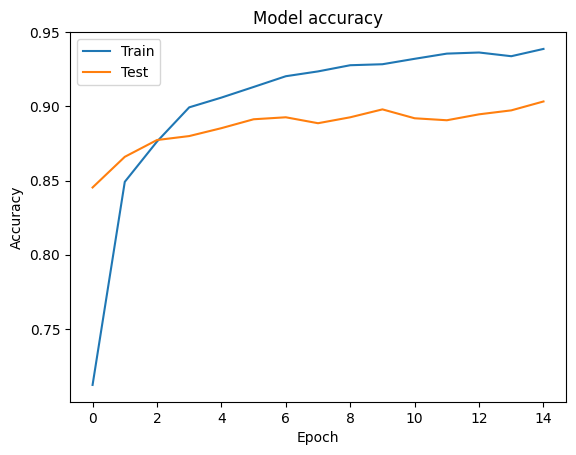

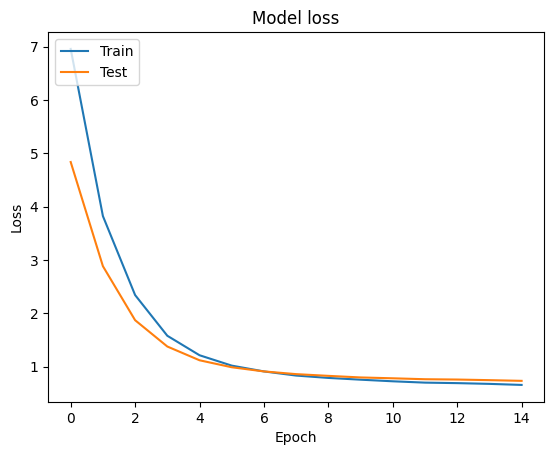

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

C:\Users\Rembrandt\AppData\Local\Temp\ipykernel_2268\2815406075.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


In [ ]:
print(test_gen.class_indices)

{'Aeseptic Cartons': 0, 'Battery': 1, 'Broken Glass': 2, 'Cardboard': 3, 'Flexible Plastic Packaging': 4, 'Glass Bottles': 5, 'Metal Cans': 6, 'Mugs': 7, 'Paper Waste': 8, 'Plastic Bags': 9, 'Plastic Bottles': 10, 'Plastic Jugs': 11, 'Plastic Utensils': 12, 'Stained Cardboard': 13, 'Styrofoam': 14}


In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=90)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')


Confusion Matrix, Without Normalization
[[91  0  0  0  6  0  1  0  0  1  0  1  0  0  0]
 [ 1 97  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0 99  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 5  0  0 86  1  0  0  0  3  1  0  0  0  1  3]
 [ 6  0  0  3 84  0  1  0  1  5  0  0  0  0  0]
 [ 1  0  0  0  1 82  4  0  1  0 10  0  0  0  1]
 [ 0  2  0  1  0  2 91  0  0  0  2  0  0  0  2]
 [ 0  2  0  0  0  0  0 96  0  0  0  1  0  0  1]
 [ 1  0  1  5  4  0  0  0 84  4  1  0  0  0  0]
 [ 1  0  0  0  0  0  1  0  1 94  0  1  0  1  1]
 [ 1  0  0  0  1  6  3  0  1  0 85  1  0  1  1]
 [ 1  0  0  0  1  3  0  0  0  0  3 92  0  0  0]
 [ 0  0  1  0  0  0  0  0  1  0  0  0 96  1  1]
 [ 0  0  0  4  0  0  0  0  1  1  0  0  0 93  1]
 [ 0  0  0  1  0  0  0  1  0  1  0  0  0  0 97]]
                            precision    recall  f1-score   support

          Aeseptic Cartons       0.84      0.91      0.88       100
                   Battery       0.96      0.97      0.97       100
              Broken Glass       

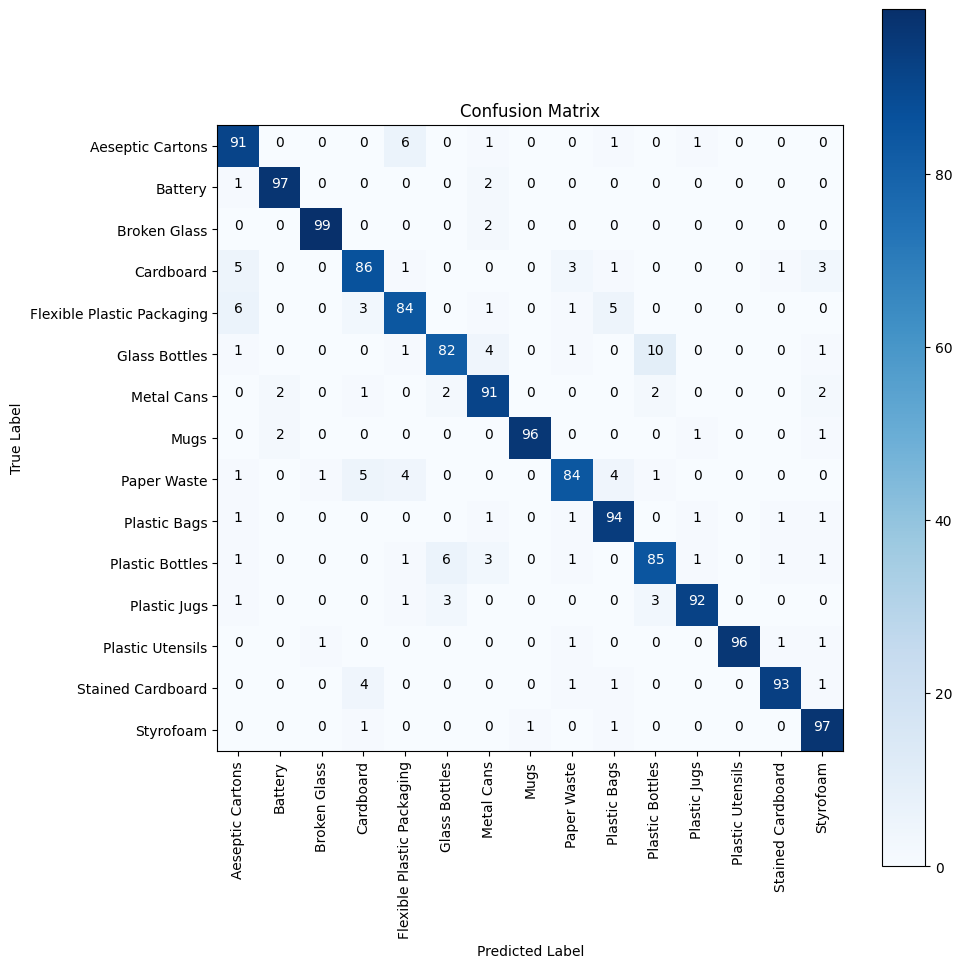

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

print()

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
model.save('15 Classes-1kimages224x224-no-scalar-final.h5')
model.save('15 Classes-1kimages224x224-no-scalar-final.keras')